### Import

In [1]:
import numpy 					as np
import pandas 					as pd
import seaborn 					as sns
from scipy 						import sparse
from sklearn.svm 				import SVC
from sklearn.svm 				import LinearSVC
from scipy.io.arff 				import loadarff
from sklearn.metrics 			import f1_score
from sklearn.metrics 			import accuracy_score
from sklearn.metrics 			import confusion_matrix
from sklearn.neighbors 			import KNeighborsClassifier
from sklearn.multiclass 		import OneVsRestClassifier

### Open

In [2]:
name = 'emotions.arff'
Raw_data = loadarff(name)
df = pd.DataFrame(Raw_data[0])

shape_columns = df.shape[1]

### Verificando atributos incompletos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 78 columns):
Mean_Acc1298_Mean_Mem40_Centroid    593 non-null float64
Mean_Acc1298_Mean_Mem40_Rolloff     593 non-null float64
Mean_Acc1298_Mean_Mem40_Flux        593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_0      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_1      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_2      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_3      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_4      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_5      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_6      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_7      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_8      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_9      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_10     593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_11     593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_12     593 

### Normalização

In [4]:
#Antes
print("\n### Min - Max ###\n")
print(pd.DataFrame([df.min(), df.max()], index = ['Min', 'Max']))
print("\n--------------------\n")

#Normalizando
normalizing_df = pd.DataFrame()

types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_values = df.select_dtypes(types)

for key in df_values:
    normalized_column = (df_values[key] - df_values[key].min())/(df_values[key].max() - df_values[key].min())
    normalizing_df[key] = normalized_column
    
    df_norm = pd.concat([normalizing_df, df.select_dtypes('object')], axis=1)
    
df = df_norm

#Depois
print("\n### Min - Max ###\n")
print(pd.DataFrame([df.min(), df.max()], index = ['Min', 'Max']))
print("\n--------------------\n")


### Min - Max ###

     Mean_Acc1298_Mean_Mem40_Centroid  Mean_Acc1298_Mean_Mem40_Rolloff  \
Min                          0.010201                         0.038286   
Max                          0.195412                         0.698277   

     Mean_Acc1298_Mean_Mem40_Flux  Mean_Acc1298_Mean_Mem40_MFCC_0  \
Min                      0.070932                      -99.090802   
Max                      0.159460                      -56.297652   

     Mean_Acc1298_Mean_Mem40_MFCC_1  Mean_Acc1298_Mean_Mem40_MFCC_2  \
Min                        0.051474                       -2.277307   
Max                       12.069754                        3.910873   

     Mean_Acc1298_Mean_Mem40_MFCC_3  Mean_Acc1298_Mean_Mem40_MFCC_4  \
Min                       -0.604609                       -1.143864   
Max                        4.382370                        2.252710   

     Mean_Acc1298_Mean_Mem40_MFCC_5  Mean_Acc1298_Mean_Mem40_MFCC_6  ...  \
Min                       -0.237114          

### Correlação

In [5]:
#Antes
print("\n### nColumns ###\n")
print(df.shape[1])
print("\n--------------------\n")

n = 0.80

types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_values = df.select_dtypes(types)

matrix_corr = df_values.corr().abs()

upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > n)]

df_corr = df.drop(df[to_drop], axis = 1)

df = df_corr

#Depois
print("\n### nColumns ###\n")
print(df.shape[1])
print("\n--------------------\n")

df_normalized = df.select_dtypes(types)
corr_matrix = df_normalized.corr().abs()
corr_matrix.style.background_gradient('coolwarm').set_precision(2)



### nColumns ###

78

--------------------


### nColumns ###

59

--------------------



### Outliers

In [6]:
#Antes
print("\n### nRows ###\n")
print(df.shape[0])
print("\n--------------------\n")

n = 2.5

name_columns = df.columns
rows = df.shape[0]
column = df.shape[1]

index = []

for i in range(column-6):
    name = name_columns[i]
    Desc = df[name].describe()
    
    #Outilier value
    Q1 = Desc[4] 
    Q3 = Desc[6]
    FIQ = Q3 - Q1
    
    l_sup = Q3 + (n*FIQ) 
    l_inf = Q1 - (n*FIQ) 
    
    for j in range(df.shape[0]):
        if j in index:
            continue
        cell_value = df[name][j]
        
        if(cell_value > l_sup) or (cell_value < l_inf):
            df.drop([j], inplace = True)
            index.append(j)
            
#Depois
print("\n### nRows ###\n")
print(df.shape[0])
print("\n--------------------\n")


### nRows ###

593

--------------------


### nRows ###

407

--------------------



### Balanceamento

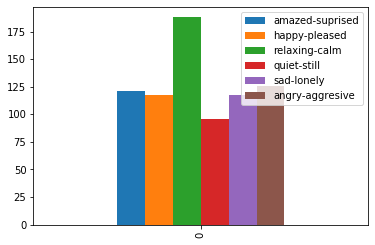

In [7]:
df_labels = df.select_dtypes('object')
labels_count = 1
labels_dict = { }
labels = []

histogram_count = {}

for key in df_labels:
    labels_dict[key] = labels_count
    labels_count += 1
    labels.append(key)
    histogram_count[key] = 0
    for values in df_labels[key]:
        if values == b'1' :
            histogram_count[key] += 1
df_histogram = pd.DataFrame([histogram_count])

df_histogram.plot.bar()

### SVM

In [8]:
n = 19

train = df.sample(frac=0.80)
test = df.drop(index = train.index)

X_train = train.iloc[:, :72-n]
Y_train = train.iloc[:,:71-n:-1]
X_test = test.iloc[:, :72-n]
Y_test = test.iloc[:,:71-n:-1]

oneVsRest = OneVsRestClassifier(SVC(kernel = 'linear',  C = 0.5)).fit(X_train, Y_train.astype(int))
y_pred = oneVsRest.predict(X_test)
Y_test_array = Y_test.astype(int).values
sparsePred = sparse.csc_matrix(y_pred)
sparseYtest = sparse.csc_matrix(Y_test_array)

acuracia = accuracy_score(sparseYtest, sparsePred, normalize = True)

### Acurácia

In [9]:
acuracia = round(acuracia*100, 2)

print("\nAcurácia : ",acuracia,"%\n")


Acurácia :  29.63 %



### Matriz de confusão

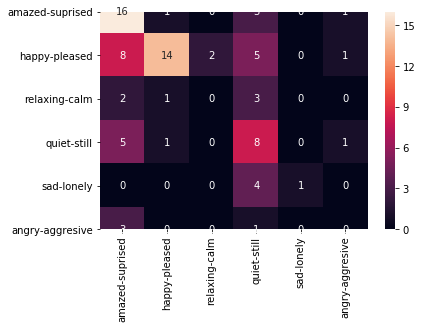

In [10]:
matrix_confusion = confusion_matrix(sparseYtest.argmax(axis=1), sparsePred.argmax(axis=1))
matrix_confusion_df = pd.DataFrame(matrix_confusion, index = labels, columns= labels)
sns.heatmap(matrix_confusion_df, annot= True)

### Score

In [11]:
f1 = pd.DataFrame([f1_score(sparseYtest, sparsePred, average='micro')], columns=['f1_Score']).round(2)

print("\nScore :",f1['f1_Score'][0]*100,"%\n")


Score : 65.0 %



### Sensibilidade

In [12]:
#######
labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

confusion_matrix = np.zeros(shape=(6,6))

for i in range(6):
    for j in range(6):
        l = labels[i]
        
        confusion_matrix[i][j] = matrix_confusion_df[l][j]
#######

sensibility = []

for i in range(0, 6):
    aux_var = 0
    rowSum = 0
    
    for j in range(0, 6):
        if(i == j):
            aux_var = confusion_matrix[i][j]
            
            rowSum += confusion_matrix[i][j]
    sensibility.append(aux_var/rowSum)
        
pd.DataFrame([sensibility], columns=labels).round(2)

C:\Users\prial\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,1.0,1.0,NaN,1.0,1.0,NaN


### Especificidade

In [13]:
sumDiagonal = 0

specificity = []

for i in range(0, 6):
    for j in range(0, 6):
        if(i == j):
            sumDiagonal += confusion_matrix[i][j]

for i in range(0, 6):
    sumCol = 0
    ownDig = 0
    
    for j in range(0, 6):
        if(i == j):
            ownDig = confusion_matrix[i][j]
        sumCol += confusion_matrix[j][i]
    tn = sumDiagonal - ownDig
    specificity.append(tn/(tn + (sumCol - ownDig)))

pd.DataFrame([specificity], columns=labels).round(2)

,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.82,0.61,0.87,0.82,0.9,0.91
